In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from phik.report import plot_correlation_matrix

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)
sns.set()

In [3]:
df = pd.read_csv('../data/raw/training_set_labels.csv')

In [4]:
display(df.sample(5))
print(f'{df.shape = }')


,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
444,'<0',48,'existing paid','used car',4788,'<100','4<=X<7',4,'male single',none,3,'life insurance',26,none,own,1,skilled,2,none,yes,good
720,'<0',24,'delayed previously',radio/tv,1659,'<100','<1',4,'female div/dep/mar',none,2,car,29,none,rent,1,'unskilled resident',1,yes,yes,bad
54,'0<=X<200',48,'critical/other existing credit',furniture/equipment,5096,'<100','1<=X<4',2,'female div/dep/mar',none,3,car,30,none,own,1,'high qualif/self emp/mgmt',1,yes,yes,bad
698,'no checking',22,'existing paid',radio/tv,2675,'500<=X<1000','>=7',3,'male single',none,4,car,40,none,own,1,skilled,1,none,yes,good
164,'no checking',6,'existing paid',furniture/equipment,4611,'<100','<1',1,'female div/dep/mar',none,4,'life insurance',32,none,own,1,skilled,1,none,yes,bad


df.shape = (800, 21)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         800 non-null    object
 1   duration                800 non-null    int64 
 2   credit_history          800 non-null    object
 3   purpose                 800 non-null    object
 4   credit_amount           800 non-null    int64 
 5   savings_status          800 non-null    object
 6   employment              800 non-null    object
 7   installment_commitment  800 non-null    int64 
 8   personal_status         800 non-null    object
 9   other_parties           800 non-null    object
 10  residence_since         800 non-null    int64 
 11  property_magnitude      800 non-null    object
 12  age                     800 non-null    int64 
 13  other_payment_plans     800 non-null    object
 14  housing                 800 non-null    object
 15  existi

In [6]:
# Сделаем названия колонок более информативными
df = df.rename(columns={
    'duration': 'duration_months',
    'employment': 'employment_years',
    'residence_since': 'residence_years',
    'age': 'age_years',
    'class': 'target'
})

In [7]:
cols2drop = []
target = ['target']
num_features = [c for c in df.columns if c not in target and pd.api.types.is_numeric_dtype(df[c])]
cat_features = [c for c in df.columns if c not in target and c not in num_features]


In [8]:
assert len(target) + len(num_features) + len(cat_features) + len(cols2drop) == len(df.columns)

In [9]:
# Изменим значения целевой переменной
df['target'] = df['target'].map(
    {'good': 0,
     'bad': 1})

# Избавимся от символов ' в значениях категориальных переменных
for c in cat_features:
    df[c] = df[c].apply(lambda x: x.strip("'"))

In [10]:
print(df.duplicated().sum())

0


Пропуски и явные дубликаты отсутствуют.  
В выборке представлено небольшое количество объектов.

In [11]:
df['target'].value_counts(normalize=True)

0   0.700
1   0.300
Name: target, dtype: float64

Существенного дисбаланса не наблюдается.

In [12]:
df.describe()

,duration_months,credit_amount,installment_commitment,residence_years,age_years,existing_credits,num_dependents,target
count,800.000,800.000,800.000,800.000,800.000,800.000,800.000,800.000
mean,21.031,3337.879,2.945,2.879,35.631,1.410,1.143,0.300
std,12.172,2866.828,1.118,1.092,11.758,0.574,0.350,0.459
min,4.000,250.000,1.000,1.000,19.000,1.000,1.000,0.000
25%,12.000,1364.000,2.000,2.000,26.000,1.000,1.000,0.000
50%,18.000,2332.000,3.000,3.000,33.000,1.000,1.000,0.000
75%,24.000,4166.000,4.000,4.000,42.000,2.000,1.000,1.000
max,60.000,18424.000,4.000,4.000,75.000,4.000,2.000,1.000


In [13]:
df[cat_features].describe(include='all')

,checking_status,credit_history,purpose,savings_status,employment_years,personal_status,other_parties,property_magnitude,other_payment_plans,housing,job,own_telephone,foreign_worker
count,800,800,800,800,800,800,800,800,800,800,800,800,800
unique,4,5,10,5,5,4,3,4,3,3,4,2,2
top,no checking,existing paid,radio/tv,<100,1<=X<4,male single,none,car,none,own,skilled,none,yes
freq,308,412,215,476,263,429,726,261,649,565,507,476,772


interval columns not set, guessing: ['duration_months', 'credit_amount', 'installment_commitment', 'residence_years', 'age_years', 'existing_credits', 'num_dependents', 'target']


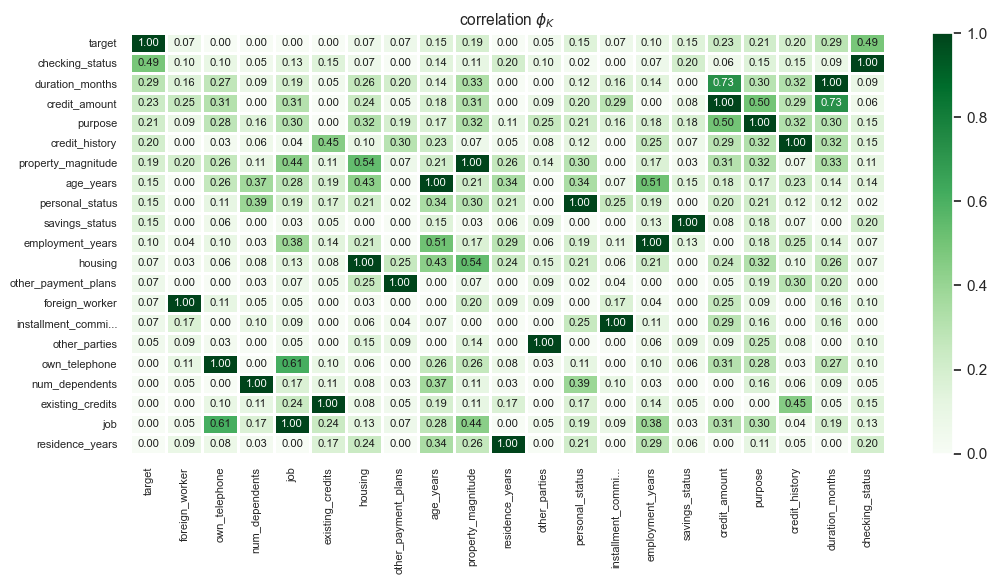

In [14]:
phik_overview = df.phik_matrix().round(2).sort_values('target')

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

interval columns not set, guessing: ['duration_months', 'credit_amount', 'installment_commitment', 'residence_years', 'age_years', 'existing_credits', 'num_dependents', 'target']


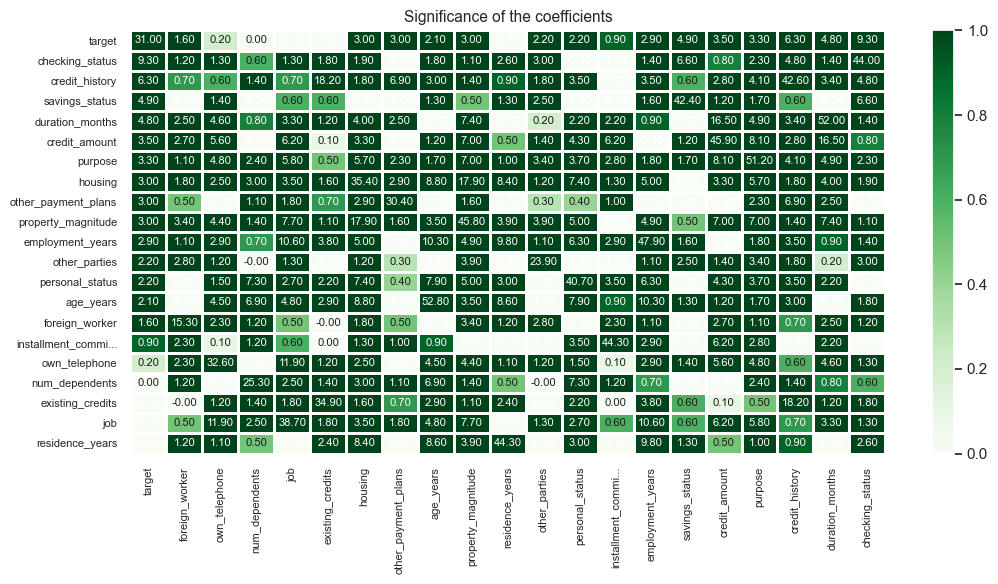

In [15]:
significance_overview = df.significance_matrix().fillna(0).round(1).sort_values('target')

plot_correlation_matrix(significance_overview.values,
                        x_labels=significance_overview.columns,
                        y_labels=significance_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients",
                        usetex=False, fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

Наибольшая корреляция c целевой переменной наблюдается у признаков checking_status, duration_months, credit_history и purpose.  Некоторые признаки демонстрируют наличие мультиколлинеарности.  
Учитывая размер выборки, необходимо будет использовать регуляризацию на этапе обучения.

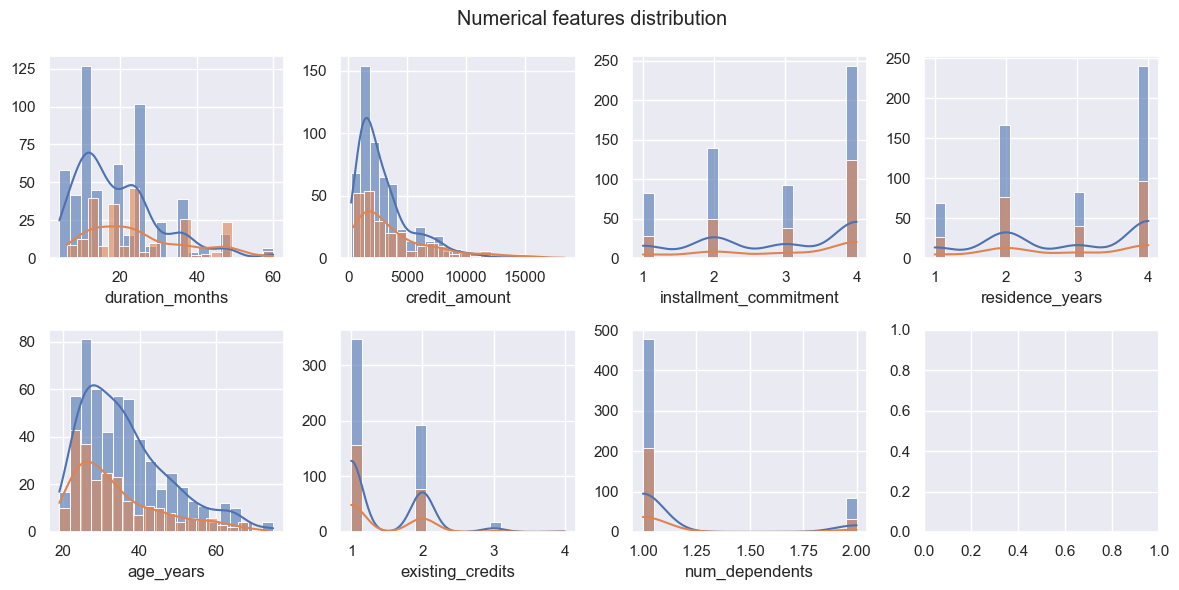

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, col in enumerate(num_features):
    ax = axes[int(i // 4), i % 4]
    for cls in df['target'].unique():
        sns.histplot(data=df[df['target'] == cls], x=col, ax=ax, kde=True, bins=20, alpha=0.6)
    ax.set_ylabel('')
fig.suptitle('Numerical features distribution')
fig.tight_layout()
plt.show()

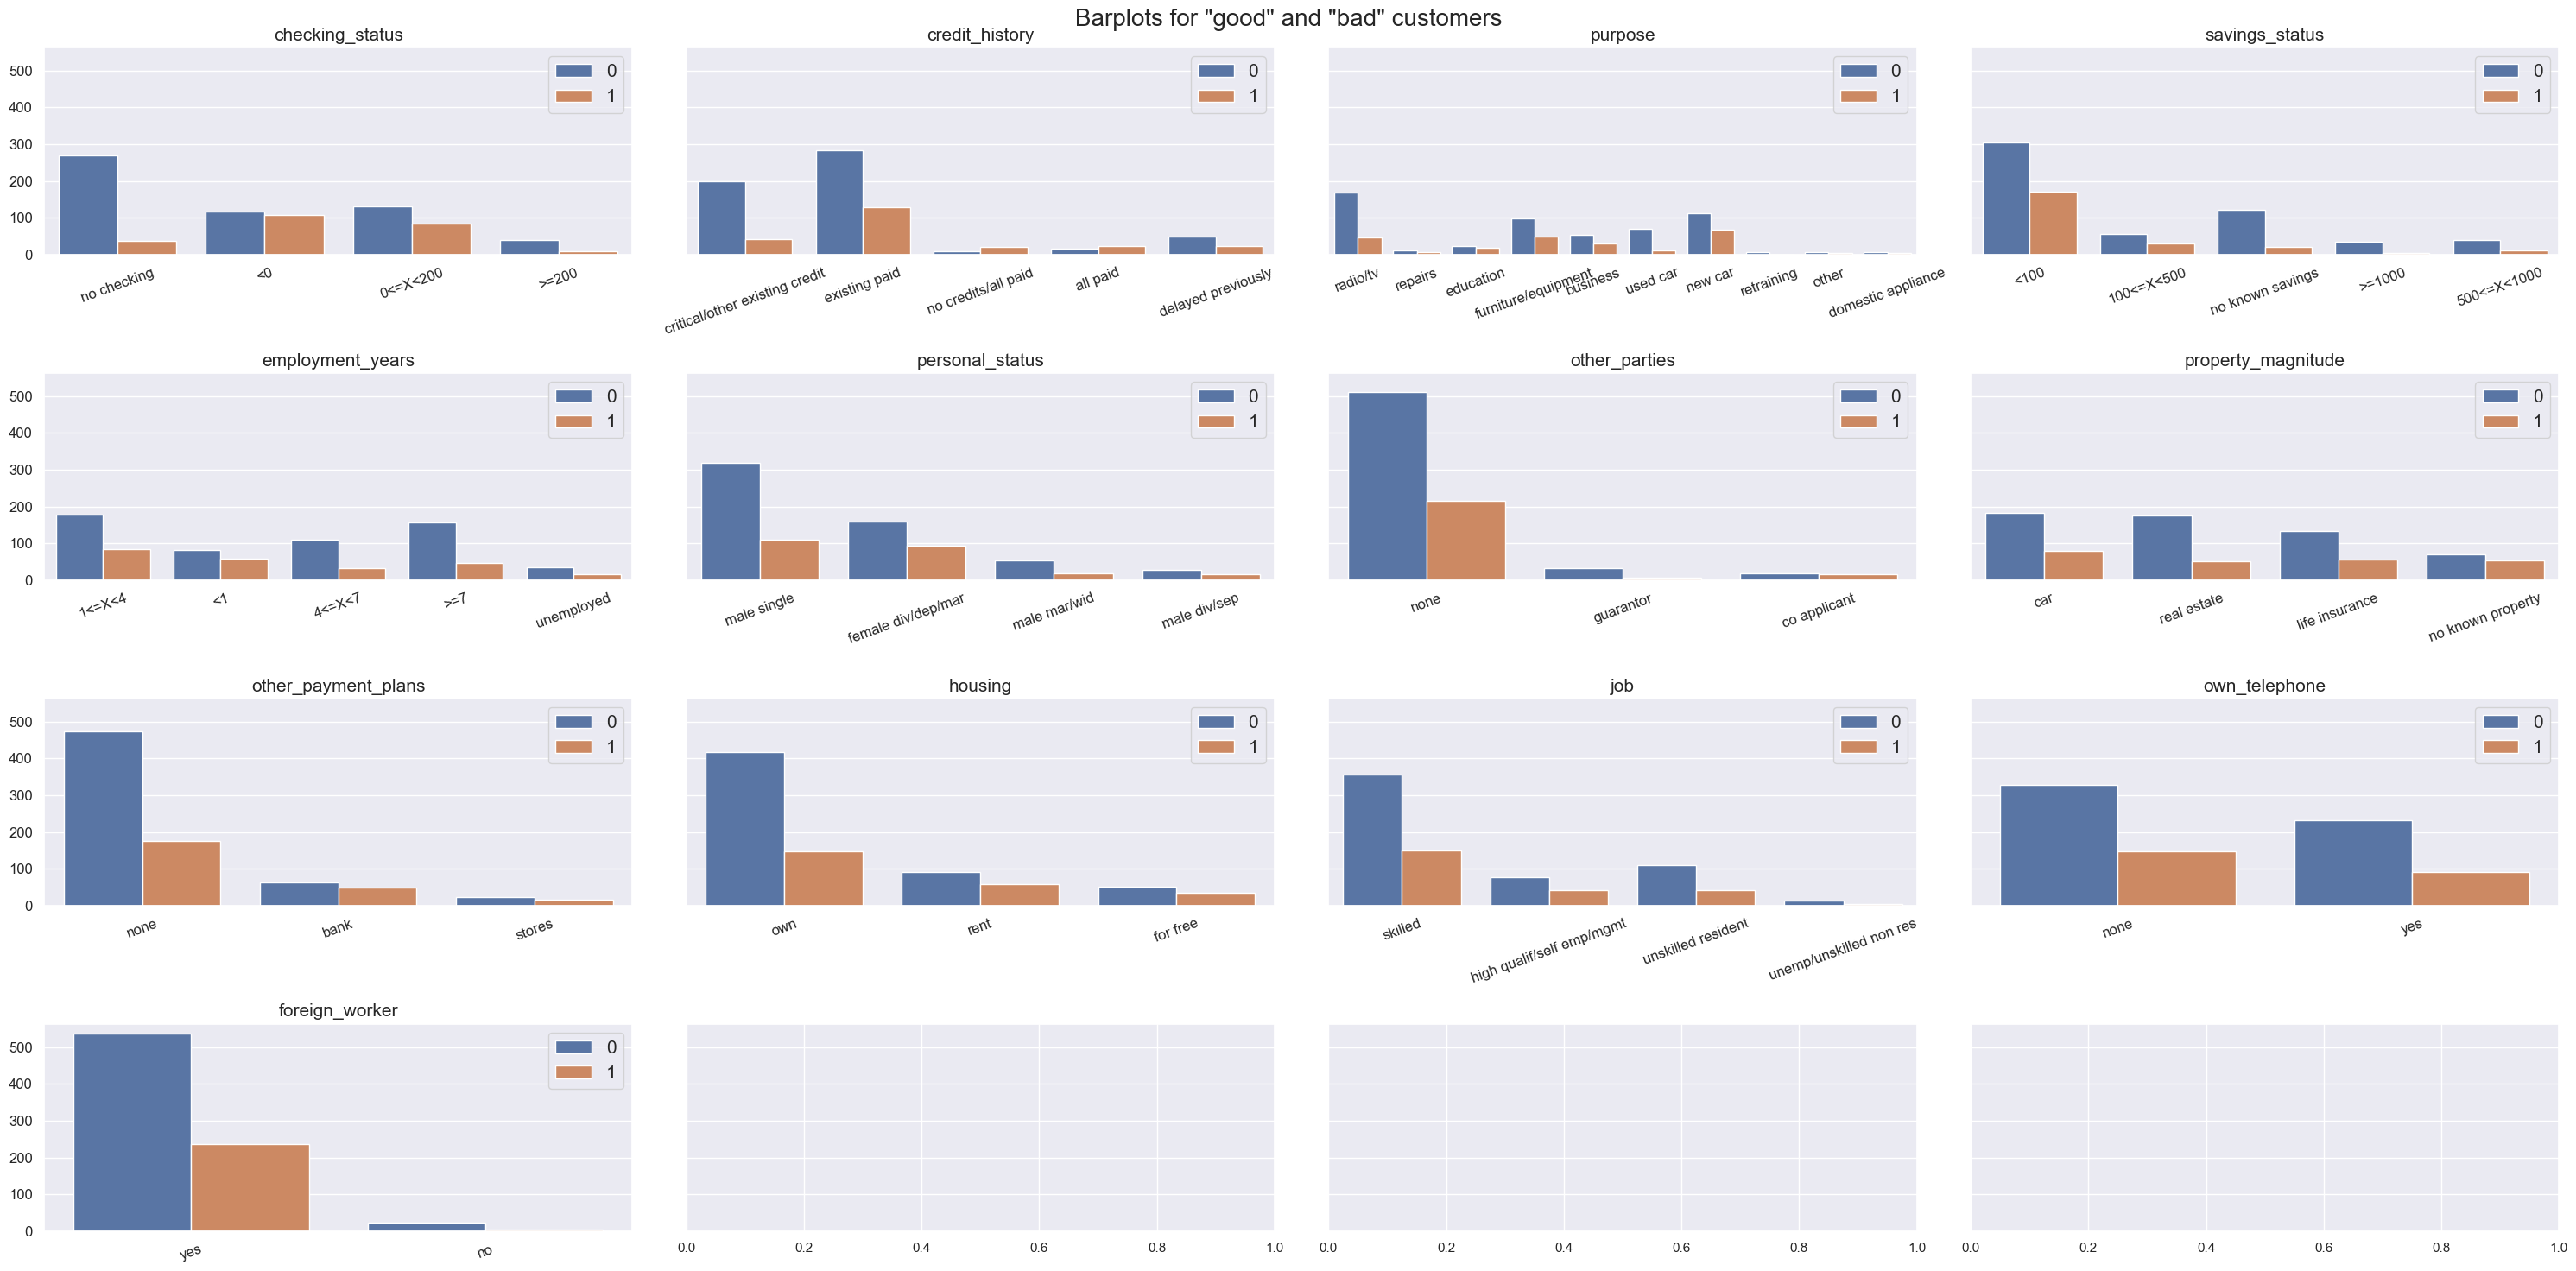

In [17]:
fig, axes = plt.subplots(4, 4, sharey=True, figsize=(30, 15))
fig.suptitle('Barplots for "good" and "bad" customers', fontsize=20)
for i, col in enumerate(cat_features):
    ax = axes[int(i / 4), i % 4]
    sns.countplot(x=col, hue='target', data=df, ax=ax).set_title(f'{col}', fontsize=15, y=1)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelsize=12)
    ax.tick_params(axis='x', labelrotation=20)
    ax.legend(fontsize=15)
fig.tight_layout()
fig.subplots_adjust(top=0.95);

Признаки checking_status и credit_history демонстрируют сильную связь с целевой переменной.  
Что довольно логично, наличие баланса счёта до 200 марок может характеризовать менее способных к накоплению средств клиентов.  
Как следствие - меньшая финансовая грамотность и выше вероятность наличия просрочки в будущем.  
Признак foreign_worker вероятно не сильно информативен.  
Учитывая размер выборки, выводы о полезности фич могут быть менее надёжными.

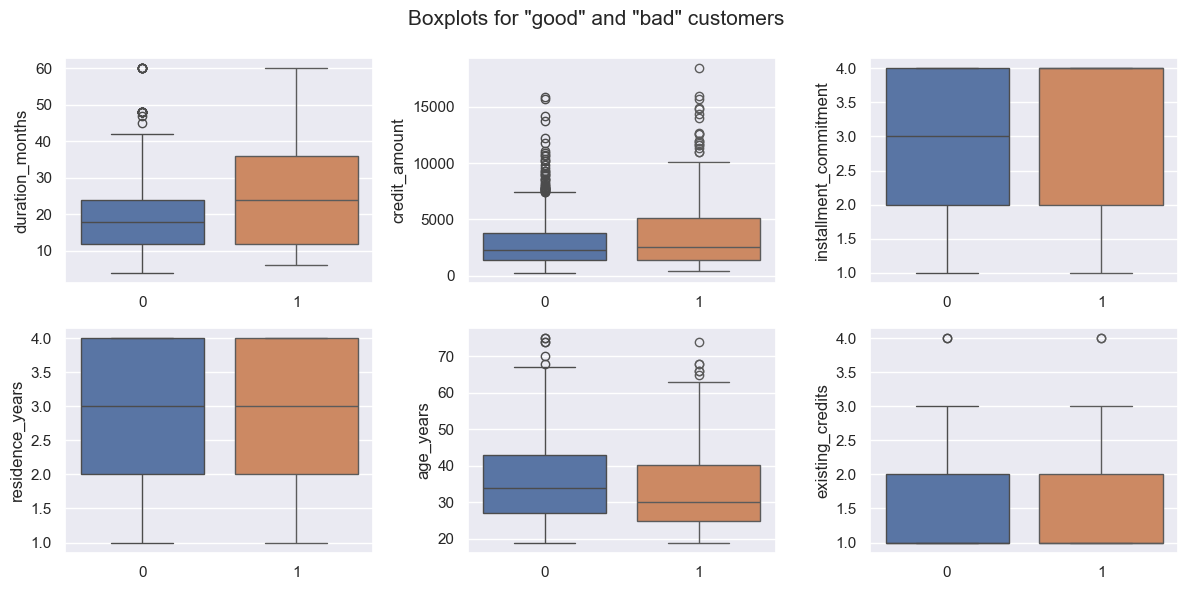

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle('Boxplots for "good" and "bad" customers', fontsize=15)

for i, col in enumerate(num_features[:-1]):
    ax = axes[int(i / 3), i % 3]

    for cls in df['target'].unique():
        sns.boxplot(x='target', y=col, data=df[df['target'] == cls], ax=ax)

    ax.set_xlabel('', fontsize=12)
    ax.set_ylabel(col, fontsize=12)

fig.tight_layout()
fig.subplots_adjust(top=0.9);

In [19]:
df.to_csv('../data/clean/train.csv', index=False)

**Вывод**:  
Датасет содержит 800 объектов и 20 столбцов с признаками, и которых 7 числовых и 13 категориальных.  
Пропуски и явные дубликаты отсутствуют.  
Доля объектов положительного класса составляет 30%.
